<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/regression_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [0]:
# weight
w = np.random.uniform(low=0.1,high=0.7,size=(1,10))

In [0]:
# train point
train_x = np.random.normal(size=(250,10))
train_x = pd.DataFrame(train_x)
train_x = train_x.sort_values(by=w.argmax())
train_x = train_x.values
train_y = train_x**2@w.T + train_x@w.T

In [0]:
# test point
test_x = np.random.normal(size=(50,10))
test_x = pd.DataFrame(test_x)
test_x = test_x.sort_values(by=w.argmax())
test_x = test_x.values
test_y = test_x**2@w.T + test_x@w.T

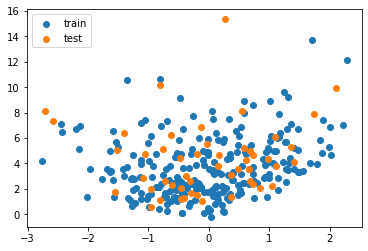

In [5]:
# plot data point
plt.scatter(train_x[:,w.argmax()],train_y,label='train')
plt.scatter(test_x[:,w.argmax()],test_y,label='test')
plt.legend()
plt.show()

# ssvm

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

# 定義模型
ssvm = nn.Sequential(nn.Linear(10,128),
                     nn.ReLU(),
                     nn.Linear(128,128),
                     nn.ReLU(),
                     nn.Linear(128,1),)

optimizer = optim.Adam(ssvm.parameters(),lr=0.001)

def loss_function(x,y,model,beta=10,e=0.001):
  
  # 加上鬆弛變量的誤差項
  error = (y-model(x))**2
  term1 = torch.norm(F.softplus(error-e,beta=beta),p=2)**2
  
  # L1正則項
  term2 = 0
  for param in model.parameters():
    term2 += torch.mean(torch.abs(param))
  
  return 0.5*term1 + 0.5*term2

def train(model,x,y,loss_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in tqdm(range(num_epochs)):
        loss = loss_function(x,y,model).sum()    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_history.append(loss.item())
    
    plt.plot(np.array(train_history),label='train')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    return model.eval()

100%|██████████| 1000/1000 [00:02<00:00, 369.05it/s]


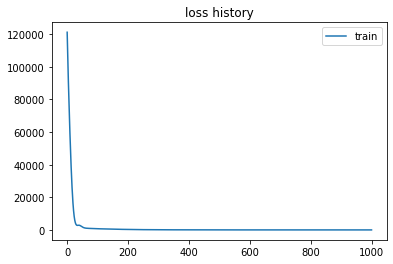

In [7]:
ssvm = train(ssvm,torch.FloatTensor(train_x),torch.FloatTensor(train_y),loss_function,optimizer,num_epochs=1000)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


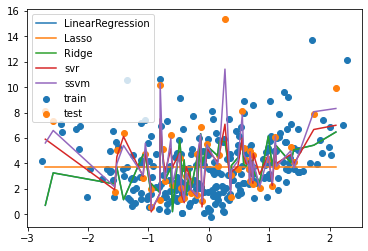

In [8]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR

# fit model
lr = LinearRegression().fit(train_x,train_y)
lasso = Lasso().fit(train_x,train_y)
ridge = Ridge().fit(train_x,train_y)
svr = SVR().fit(train_x,train_y)

# plot predict
plt.plot(test_x[:,w.argmax()],lr.predict(test_x),label='LinearRegression')
plt.plot(test_x[:,w.argmax()],lasso.predict(test_x),label='Lasso')
plt.plot(test_x[:,w.argmax()],ridge.predict(test_x),label='Ridge')
plt.plot(test_x[:,w.argmax()],svr.predict(test_x),label='svr')
plt.plot(test_x[:,w.argmax()],ssvm(torch.FloatTensor(test_x)).detach().numpy().ravel(),label='ssvm')

# plot data point
plt.scatter(train_x[:,w.argmax()],train_y,label='train')
plt.scatter(test_x[:,w.argmax()],test_y,label='test')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import r2_score

table = pd.DataFrame(index=['LR','LASSO','RIDGE','SSVM','SVR'],columns=['R2'])
table.loc['LR','R2'] = r2_score(test_y,lr.predict(test_x))
table.loc['LASSO','R2'] = r2_score(test_y,lasso.predict(test_x))
table.loc['RIDGE','R2'] = r2_score(test_y,ridge.predict(test_x))
table.loc['SVR','R2'] = r2_score(test_y,svr.predict(test_x))
table.loc['SSVM','R2'] = r2_score(test_y,ssvm(torch.FloatTensor(test_x)).detach().numpy().ravel())

In [10]:
table = table.astype('float')
table.style.background_gradient(axis=0)

,R2
LR,0.175796
LASSO,-0.040976
RIDGE,0.176188
SSVM,0.916909
SVR,0.720570
